# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

## 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
try:
    df = pd.read_csv('C:/Users/111/Desktop/real_estate_data.csv', sep='\t') # прочитаем файл с разделителем "\t"
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv',  sep='\t')
    
df.head()#выведем на экран первые 5 строк 

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
df.info()#откроем информацию о датасете.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
df.duplicated().sum()# получим информацию о явных дубликатах

0

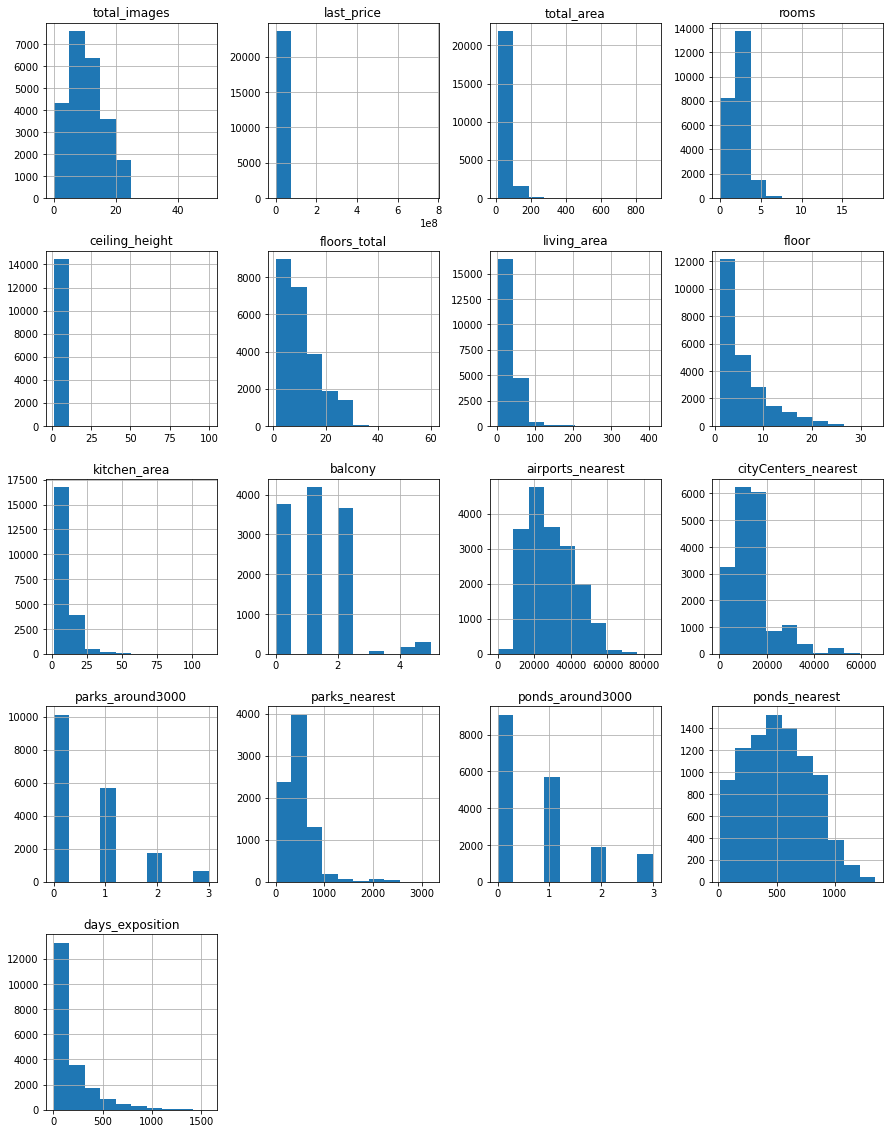

In [5]:
#строим гистограмму для всх числовых столбцов
df.hist(figsize=(15, 20))
plt.show()

***Вывод***


Всего у нас 23699 записи. Для целого ряда столбцов есть пропущенные значения и некорректный тип данных. По ряду признаков присутствуют аномальные значения

Данные пригодны для работы.

## 2. Предобработка данных 

In [6]:
# приводим значение last_price в  целочисленный 
df['last_price'] = df['last_price'].astype(int)
# меняем тип даты в столбце first_day_exposition
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
# в столбце is_apartment указано является квартира апартаментами или нет True-явлется, False-не апартаменты.
# NaN в этом столбце могло появиться из-за того, что пользователь мог не указать этот пораметр потому, что квартира не апартаменты.
#заменим пропущеные значения на False 
df['is_apartment'] = df['is_apartment'].fillna(value=False)
# приводим в целочисленный тип количество балконов. Заменяем пропущенные значения на 0
# скорее всего пропуски в этом столце вызваны отсутствием балкона
df['balcony'] = df['balcony'].fillna(value=0).astype(int)
# приводим в целочисленный тип количество парков. Заменяем пропущенные значения на 0
# пропущеное значение скорее всего говорит об отсутствии парков поблизости 
df['parks_around3000'] = df['parks_around3000'].fillna(value=0).astype(int)
# Приводим в целочисленный тип количество прудов. Заменяем пропущенные значения на 0
# пропущеное значение скорее всего говорит об отсутствии водоемов поблизости 
df['ponds_around3000'] = df['ponds_around3000'].fillna(value=0).astype(int)


In [7]:
df.isnull().sum()# проверяем колличество пропущеных значений 

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000            0
parks_nearest           15620
ponds_around3000            0
ponds_nearest           14589
days_exposition          3181
dtype: int64

<div class="alert alert-block alert-warning">

**Комментарий ревьювера (что можно улучшить)**
    
Лучше сначала изучить пропуски, определить возможную причину их появления и только потом выполнять восстановление.    

</div>

In [8]:
# Удаляем записи, где отсутствует локация и этажность
# Так как если заполнить эти данные медианным значением, это может исказить иследование floors_total=86, locality_name = 49          
df.dropna(subset=['locality_name'], inplace=True)
df.dropna(subset=['floors_total'], inplace=True)

# Приводим этажность к целочисленному типу
df['floors_total'] = df['floors_total'].astype(int)

В столбце ***ceiling_height*** 9195 пропущенных значенией, это может существенно повлиять на дальнейшее иследование, поэтому заполним пропуски медианным значением.

In [9]:
#заменяем значения высоты потолков на медианное значение
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())

Переходим к значению ***жилой площади***(living_area) и ***(площади кухни***((kitchen_area). Эти данные нам еще пригодятся для анализа, поэтому заполним провуски:

living_area - ***жилая площадь.***

Находится как разница между ***общей площадью*** (total_area) и площадью коридора, кухни, сан. узла, балкона и тд)

kitchen_area - ***площадь кухни***


Жилую площади можно найти путем: 

1) найдем отношение медианой жилой площади и медианной общей площади. Таким образом у нас появится коэфициент (K)
2) Этот коэфициент умножим на на общую площать

Площади кухни находим индентично жилой площади 

kk- коэфициент площади кухни от общей площади 


In [10]:
# Заменяем пустые значения жилой площади и площади кухни
living_k = df['living_area'].mean() / df['total_area'].mean() # вычисляем коэф.жилой площади
kitchen_kk = df['kitchen_area'].mean() / df['total_area'].mean() #вычисляем коэф.кухни
df['living_area'].fillna(living_k * df['total_area'], inplace=True)
df['kitchen_area'].fillna(kitchen_kk * df['total_area'], inplace=True)


In [11]:
# Проверяем количество пропущенных значений
df.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000            0
parks_nearest           15535
ponds_around3000            0
ponds_nearest           14529
days_exposition          3171
dtype: int64

Так же замением название столбца cityCenters_nearest, на city_сenters_nearest



In [12]:
# меняем название столбца cityCenters_nearest на city_сenters_nearest
df.rename(columns = {'cityCenters_nearest':'city_centers_nearest'}, inplace = True )

Провверим местоположение квартиры (locality_name) и заменим неявные дубликаты.

Поменеяем букву ё на букву е

А так же уберем из названия уточнение местоположения, таких как "поселок", "село" и тд.

А пропуски заполняем "неизвестно", так как нет возможности указать местоположение квартиры



In [13]:
df['locality_name'] = df['locality_name'].str.lower() #меняем все названия на строчные
df['locality_name'] = (
    df['locality_name']
    .str.replace('ё','е')# меняем ё на е
#пропуски в данном столбце лучше будет заменить на "неизвестно", так как нельзя точно определить район расположения!
    .replace(['поселок ','при железнодорожной станции ', 'платформа ', 'садоводческое некоммерческое товарищество ',
             'садовое товарищество ', 'станции ', 'село ', 'пансионат ', 'городского типа ',
             'деревня ', 'городской поселок '], '', regex=True)# оставляем только общие значение местоположения квартиры 
)
#пропуски в данном столбце лучше будет заменить на "неизвестно", так как нельзя точно определить район расположения!
df['locality_name'] = df['locality_name'].fillna('неизвестно')
df['locality_name'].unique()

array(['санкт-петербург', 'шушары', 'городской янино-1', 'парголово',
       'мурино', 'ломоносов', 'сертолово', 'петергоф', 'пушкин',
       'кудрово', 'коммунар', 'колпино', 'красный бор', 'гатчина',
       'федоровское', 'выборг', 'кронштадт', 'кировск', 'новое девяткино',
       'металлострой', 'лебяжье', 'сиверский', 'молодцово',
       'кузьмоловский', 'новая ропша', 'павловск', 'пикколово',
       'всеволожск', 'волхов', 'кингисепп', 'приозерск', 'сестрорецк',
       'куттузи', 'аннино', 'ефимовский', 'плодовое', 'заклинье',
       'торковичи', 'первомайское', 'красное село', 'понтонный',
       'сясьстрой', 'старая', 'лесколово', 'новый свет', 'сланцы',
       'путилово', 'ивангород', 'шлиссельбург', 'никольское',
       'зеленогорск', 'сосновый бор', 'оржицы', 'кальтино', 'романовка',
       'бугры', 'рощино', 'кириши', 'луга', 'волосово', 'отрадное',
       'павлово', 'оредеж', 'копорье', 'молодежное', 'тихвин', 'победа',
       'нурма', 'синявино', 'тосно', 'стрельна', 'бокс

## Вывод



В процессе предобработки данных:

Переименовали название столбца cityCenters_nearest на city_centers_nearest.

Заполнили явные пропуски в таблице, а так же неявные дубликаты.

Изменили тип данных, в соответствии с данными находяшимися в столбцах.



Причины пропусков могли стать:

-Человеческий фактор

-Остутствие обязательных полей для заполнения внутри программы

-Програмный сбой

Это можно было бы избежать если каждая категория будет обязательной для заполнения. В этом случае по каждой квартире будет одинаково полный набор данных


## Рассчёты и добавление результатов в таблицу

Добавим в таблицу следующие столбцы :

***Цена одного квадратного метра***

Цена одного квадратного метра - это отношение общей площади к цене объекта 

***День недели публикации объявления*** 

Присвоем дню недели значение от 0-6

(0 — понедельник, 1 — вторник и так далее)

***Месяц публикации объявления***

***Год публикации объявления***

***Тип этажа квартиры***

- Первый этаж обозначим как "первый"
- последний обозначим как "последний"
- остальные этажи запишим как "другие" 

***Расстояние до центра города в километрах***

Переведем метры в километры.

In [14]:
# Добавляем столбец со стоимостью квадратного метра (sm_price) и приводим его в целочисленный тип
df['sm_price'] = df['last_price'] / df['total_area']
df['sm_price'] = df['sm_price'].astype(int)

# Добавляем столбцы дня недели, месяца и года
df['weekday'] = df['first_day_exposition'].dt.weekday
df['month'] = df['first_day_exposition'].dt.month
df['year'] = df['first_day_exposition'].dt.year

# Добавляем столбец с отношением жилой площади к общей (area_ratio), переводим в % и приводим его в целочисленный тип
df['area_ratio'] = df['living_area'] / df['total_area'] * 100
df['area_ratio'] = df['area_ratio'].fillna(value=0).astype(int)

# Добавляем столбец с отношением площади кухни к общей (kitchen_ratio), переводим в % и приводим его в целочисленный тип
df['kitchen_ratio'] = df['kitchen_area'] / df['total_area'] * 100
df['kitchen_ratio'] = df['kitchen_ratio'].fillna(value=0).astype(int)

# Создаём функцию для заполнения нового столбца с типом этажа
def floor_group(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
df['floor_type'] = df.apply(floor_group, axis=1)

#Переводим метры в километры в столбце, делим значение city_сenters_nearest на 1000.
#Округлим до целого числа
df['distans'] = (df['city_centers_nearest']/1000).round(0)# перезаписываем значение в столбец distans

## Исследовательский анализ данных

### 1. Основные параметры

Изучим основыные параметры и построим отдельные гистограмы для каждого.

Если в данных будут встреаться редкие выбивающиеся значения, то будем убирать их или заменять.

Основыне параметры, для которых будет постоена гистограмма:
- общая площадь;
- жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- тип этажа квартиры («первый», «последний», «другой»);
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего парка

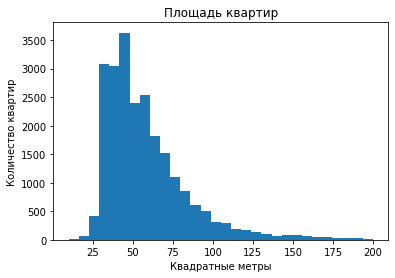

Наибольшие по площади варианты:
19540    900.0
12859    631.2
3117     631.0
15651    618.0
5358     590.0
4237     517.0
8018     507.0
15016    500.0
5893     500.0
12401    495.0
Name: total_area, dtype: float64


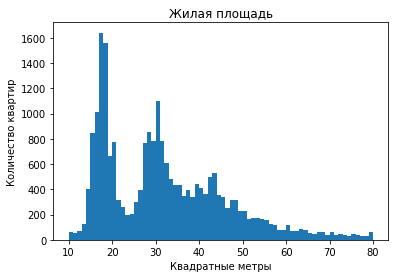

Наибольшие по жилой площади варианты:
19540    409.700000
5358     409.000000
3117     360.410721
12401    347.500000
4237     332.000000
12859    322.300000
660      312.500000
8018     301.500000
14088    300.000000
5893     285.586942
Name: living_area, dtype: float64


In [15]:
# Работаем с площадью
plt.hist(df['total_area'], bins=30, range=(10,200))#строем гистограмму по столбцу total_area, с 30 карзинами и разбросом значений от 10 до 200 
plt.title('Площадь квартир')
plt.xlabel('Квадратные метры')
plt.ylabel('Количество квартир')
plt.show()
print('Наибольшие по площади варианты:')
print(df['total_area'].sort_values(ascending=False).head(10))


# Работаем с жилой площадью
plt.hist(df['living_area'], bins=70, range=(10,80))
plt.title('Жилая площадь')
plt.xlabel('Квадратные метры')
plt.ylabel('Количество квартир')
plt.show()
print('Наибольшие по жилой площади варианты:')
print(df['living_area'].sort_values(ascending=False).head(10))




***Площадь*** -total_area

Большинство квартир - менее 100 квадратных метров, больше площадь практически не встречается. В подборке есть несколько очень больших и странных вариантов с площадью более 200 квадратных метров.

***Жилая площадь*** -living_area

Самые распространённые варианты с жилой площадью от 10 до 50 метров. После 80 метров встречаются единичные случаи. Два пика графика вызваны, вероятно, тем, что это жилые площади для 1-комнатной, затем для 2-комнатной и после этого для 3-комнатной квартиры.


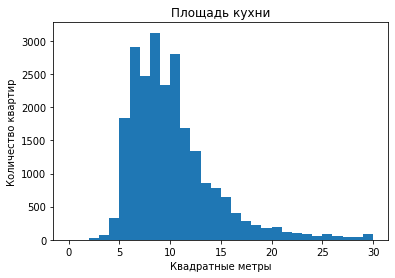

Наибольшие по площади кухни варианты:
19540    112.000000
20215    107.000000
2489     100.700000
5358     100.000000
16239     93.200000
16797     93.000000
15016     87.537299
10867     87.200000
9826      86.504359
492       77.000000
Name: kitchen_area, dtype: float64


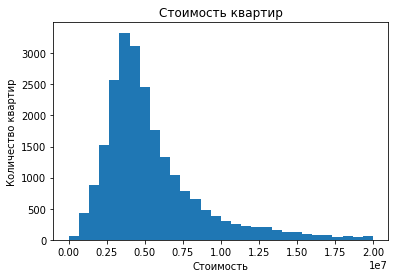

Наибольшие по цене варианты:
12971    763000000
19540    420000000
14706    401300000
1436     330000000
15651    300000000
22831    289238400
16461    245000000
13749    240000000
5893     230000000
8900     190870000
Name: last_price, dtype: int64


In [16]:
# Работаем с площадью кухни
plt.hist(df['kitchen_area'], bins=30, range=(0,30))
plt.title('Площадь кухни')
plt.xlabel('Квадратные метры')
plt.ylabel('Количество квартир')
plt.show()
print('Наибольшие по площади кухни варианты:')
print(df['kitchen_area'].sort_values(ascending=False).head(10))


# Работаем со стоимостью
plt.hist(df['last_price'], bins=30, range=(0,20000000))
plt.title('Стоимость квартир')
plt.xlabel('Стоимость')
plt.ylabel('Количество квартир')
plt.show()
print('Наибольшие по цене варианты:')
print(df['last_price'].sort_values(ascending=False).head(10))

***Площадь кухни*** - kitchen_area

Самые распространённые кухни - от 5 до 15 метров. Больше 20 метров кухни практически не встречаются. Больше 30 - единичные случаи.

***Стоимость*** -last_price

В основном стоимость квартир - порядка 5 миллионов. Больше 20 миллионов вариантов мало и они выглядят очень странно и некоторые - на порядок дороже.

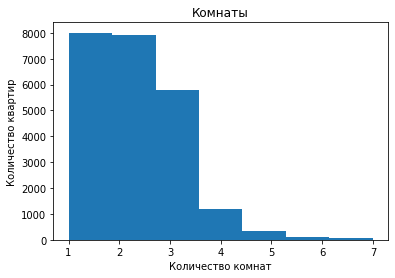

Наибольшие по числу комнат варианты:
14498    19
18848    16
5358     15
20829    14
866      14
19540    12
648      11
9688     11
18891    10
18119    10
Name: rooms, dtype: int64


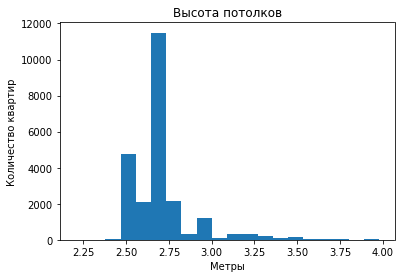

Наибольшие по высоте потолков варианты:
22869    100.0
3148      32.0
22336     32.0
21377     27.5
5807      27.0
5246      27.0
10773     27.0
17857     27.0
21824     27.0
20478     27.0
Name: ceiling_height, dtype: float64


In [17]:
# Работаем с комнатами
plt.hist(df['rooms'], bins=7, range=(1,7))
plt.title('Комнаты')
plt.xlabel('Количество комнат')
plt.ylabel('Количество квартир')
plt.show()
print('Наибольшие по числу комнат варианты:')
print(df['rooms'].sort_values(ascending=False).head(10))

# Работаем с потолками
plt.hist(df.query('(ceiling_height > 2) & (ceiling_height < 4)')['ceiling_height'], bins=20)
plt.title('Высота потолков')
plt.xlabel('Метры')
plt.ylabel('Количество квартир')
plt.show()
print('Наибольшие по высоте потолков варианты:')
print(df['ceiling_height'].sort_values(ascending=False).head(10))

***Комнаты*** -rooms

В основном квартиры состоят из 1, 2 и 3 комнат. Есть небольшая доля 4-комнатных квартир. Варианты, где больше 7 комнат выглядят странно и подозрительно. Даже при объединении нескольких квартир в одну это подозрительно. Возможно, это отдельный дом.

***Высота потолков*** -ceiling_height

Большинство вариантов имеют высоту потолков от 2,5 до 3 метров. Больше 4 метров высота потолков выглядит подозрительно. Есть значения в 27 метров (высота 9-этажного дома) - это может быть ошибкой данных и реальная высота 2,7 метра.


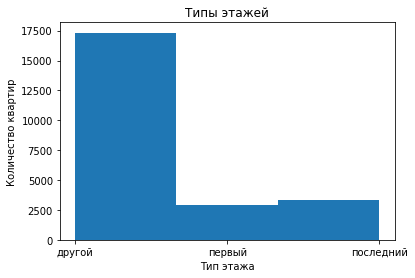

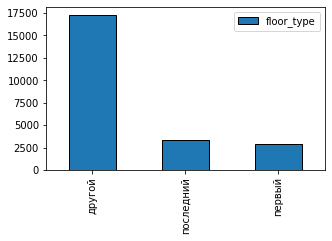

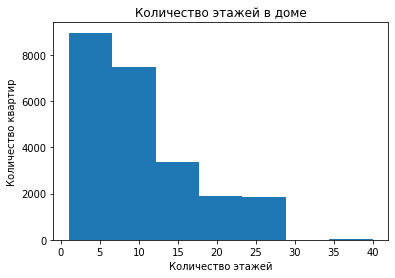

Наибольшие по числу этажей:
2253     60
16731    52
16934    37
5807     36
11079    36
397      36
13975    35
2966     35
9186     35
1917     35
Name: floors_total, dtype: int64


In [18]:
# Работаем с типом этажа квартиры
plt.hist(df['floor_type'], bins=3)
plt.title('Типы этажей')
plt.xlabel('Тип этажа')
plt.ylabel('Количество квартир')
plt.show()

df['floor_type'].value_counts().plot.bar(figsize=(5, 3), ec='black', legend=True)
plt.show()



# Работаем с общим колличеством этажей в доме
plt.hist(df['floors_total'], bins=7, range=(1,40))
plt.title('Количество этажей в доме')
plt.xlabel('Количество этажей')
plt.ylabel('Количество квартир')
plt.show()
print('Наибольшие по числу этажей:')
print(df['floors_total'].sort_values(ascending=False).head(10))


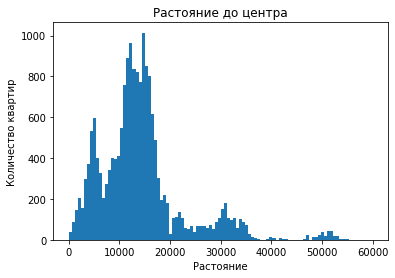

Наибольшие удаление от центра:
9640     65968.0
5340     65952.0
577      65764.0
20746    65105.0
5218     64857.0
18884    62706.0
2974     62454.0
16569    61495.0
23123    60223.0
4441     59626.0
Name: city_centers_nearest, dtype: float64


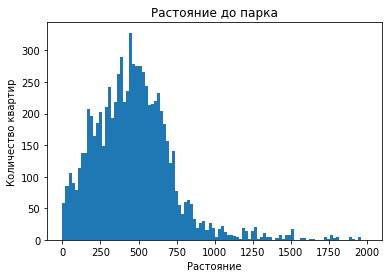

Наибольшие удаление от парка:
10959    3190.0
19430    3190.0
1590     3064.0
19208    3013.0
23080    2984.0
2659     2905.0
1860     2888.0
7855     2880.0
3865     2847.0
22003    2768.0
Name: parks_nearest, dtype: float64


In [19]:
# Работаем с растоянием до центра города
plt.hist(df['city_centers_nearest'], bins=100, range=(0,60000))
plt.title('Растояние до центра')
plt.xlabel('Растояние')
plt.ylabel('Количество квартир')
plt.show()
print('Наибольшие удаление от центра:')
print(df['city_centers_nearest'].sort_values(ascending=False).head(10))

# Работаем с растоянием до ближайшего парка

plt.hist(df['parks_nearest'], bins=100, range=(0,2000))
plt.title('Растояние до парка')
plt.xlabel('Растояние')
plt.ylabel('Количество квартир')
plt.show()
print('Наибольшие удаление от парка:')
print(df['parks_nearest'].sort_values(ascending=False).head(10))


***Расстояние до центра города в метрах***

У большинства объявлений, расстояние до центра города меньше 20000 метров, что приравнивается 20 км. Так же присутствуют квартиры, удаление которых, от центра больше 30000 метров (30 км) скорее всего, эти дома расположены в ближайших к городу поселков, или деревень.

***Растояние до ближайшего парка*** 

Большенство квартир расволожены рядом с парком, до которого менее 1000 метров. При этом так же присутствуют объявления, в которых растояние до парка значительно больше 


***Вывод:***

***Площадь***

Большинство квартир - менее 100 квадратных метров, больше площадь практически не встречается. В подборке есть несколько очень больших и странных вариантов с площадью более 200 квадратных метров.

***Жилая площадь***

Самые распространённые варианты с жилой площадью от 10 до 50 метров. После 80 метров встречаются единичные случаи. Два пика графика вызваны, вероятно, тем, что это жилые площади для 1-комнатной, затем для 2-комнатной и после этого для 3-комнатной квартиры.

***Площадь кухни***

Самые распространённые кухни - от 5 до 15 метров. Больше 20 метров кухни практически не встречаются. Больше 30 - единичные случаи.

***Стоимость***

В основном стоимость квартир - порядка 5 миллионов. Больше 20 миллионов вариантов мало и они выглядят очень странно и некоторые - на порядок дороже.

***Комнаты***

В основном квартиры состоят из 1, 2 и 3 комнат. Есть небольшая доля 4-комнатных квартир. Варианты, где больше 7 комнат выглядят странно и подозрительно. Даже при объединении нескольких квартир в одну это подозрительно. Возможно, это отдельный дом.

***Высота потолков***

Большинство вариантов имеют высоту потолков от 2,5 до 3 метров. Больше 4 метров высота потолков выглядит подозрительно. Есть значения в 27 метров (высота 9-этажного дома) - это может быть ошибкой данных и реальная высота 2,7 метра.

***Тип этаже квартиры***

Большенство этажей продается не на первом и не на последнем, скорее всего эти квартиры не полюзуются спросом и популярностью.

***Общее количество этажей в доме***

Большенство квартир - это пятиэтажные дома, видна так же линейная зависимости с увеличением квартир уменьшается колличество предложений на рынке недвижимости.

Так же имеентся значение 60 этажей, скорее всего это ошибочное значение, вероятнее всего количество этажей в доме 6

***Расстояние до центра города в метрах***

У большинства объявлений, расстояние до центра города меньше 20000 метров, что приравнивается 20 км. Так же присутствуют квартиры, удаление которых, от центра больше 30000 метров (30 км) скорее всего, эти дома расположены в ближайших к городу поселков, или деревень.

***Растояние до ближайшего парка*** 

Большенство квартир расволожены рядом с парком, до которого менее 1000 метров. При этом так же присутствуют объявления, в которых растояние до парка значительно больше 




### 2. Изучение времени продажи квартиры


Изучим как быстро продавались квартиры и запишем получившееся значение в столбец ***days_exposition***

Этот параметр показывает, сколько дней было размещено каждое объявление.

Избавимся от выбросов в данных, для более точного анализа

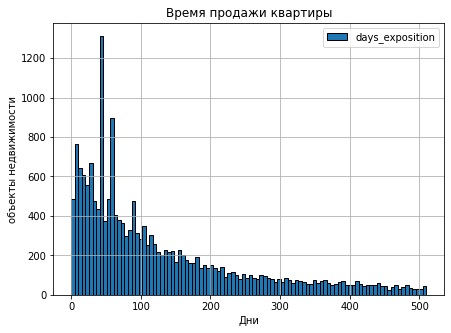

In [20]:
# Рассчитаем Q1, Q3 и IQR для построения графика без выбросов
q1 = df['days_exposition'].quantile(.25) # первый квартиль Q1
q3 = df['days_exposition'].quantile(.75) # третий квартиль Q3
iqr = q3 - q1 # межквартильный размах IQR



# Построим гистограмму времени продажи квартиры
df['days_exposition'].hist(bins=100, range=(0, (q3 + 1.5 * iqr)), figsize=(7, 5), ec='black', legend=True)
plt.title('Время продажи квартиры')
plt.xlabel('Дни')
plt.ylabel('объекты недвижимости')
plt.show()

На графике видны пики около 50-60 дней, но при таком длинном "хвосте" из данных делать выводы не уместно. Изменим масштаб - изменим период до 100 дней.

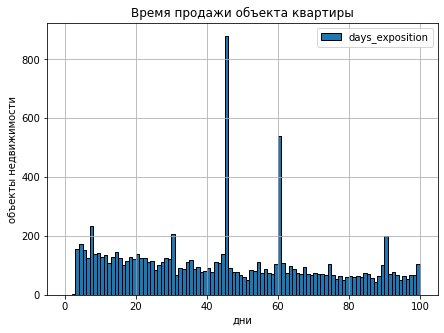

In [21]:
# Ограничим гистограмму периодом до 100 дней
df['days_exposition'].hist(bins=100, range=(0, 100), figsize=(7, 5), ec='black', legend=True)
plt.title('Время продажи объекта квартиры')
plt.xlabel('дни')
plt.ylabel('объекты недвижимости')
plt.show()

Судя по графику, чаще всего квартиры продают за 45 и 60 дней. 

Теперь посмотрим на среднее и медиану.

In [22]:
# Получим описательную статистику столбца days_exposition
df['days_exposition'].describe()

count    20394.000000
mean       180.741395
std        219.732782
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

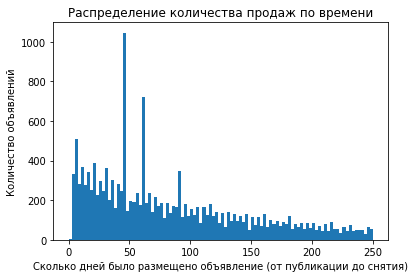

In [23]:
plt.hist(df['days_exposition'],
         bins=100,
         range=(0,250)
        )
plt.title('Распределение количества продаж по времени')
plt.xlabel('Сколько дней было размещено объявление (от публикации до снятия)')
plt.ylabel('Количество объявлений')
plt.show()

***Вывод:***

Среднее значение продажи составляет 180 дня, при этом медианное значение составляет 95 дня, оно более точно характеризует среднее время продажи, так как не зависит от выбрасов и нестандартных значений.

В среднем продажа среднестатистичекой квартиры занимает 2-3 месяца в зависимотсти от сопутствующих факторов.

Быстрыми продажами можно считать продажи состоявшиеся за 45 днней (в первом квартиле), а необычно долгие продажи после 232 дня и более (после 3 квартиля), которые вообще могут быть не проданными.

***Вывод***

Медианное время продажи - 95 дней. Среднее время продажи - 181 день.
В основном квартиры продаются за срок в 100 дней. Есть большое число квартир, проданных за несколько дней после публикации. А также есть варианты, которые продавались несколько десятков месяцев.

Быстрой продажей можно назвать срок в 45 дней и меньше. Долгой продажей - 200 дней  и дольше.

### Определим факторы, которые больше всего влияют на общую (полную) стоимость объекта.

Проверим зависит ли цена от:
- общей площади;
- жилой площади;
- площади кухни;
- количества комнат;
- этажа, на котором расположена квартира (первый, последний, другой);
- даты размещения (день недели, месяц, год).

Воспользуемся библиотекой seaborn и рафиком heatmap

In [24]:
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'sm_price', 'weekday', 'month',
       'year', 'area_ratio', 'kitchen_ratio', 'floor_type', 'distans'],
      dtype='object')

In [25]:
# Создадим список с параметрами для проверки
corr_param = [
    'last_price',
    'total_area',
    'living_area',
    'kitchen_area',
    'rooms',
    'weekday',
    'month',
    'year']

In [26]:
corr_name_rus = [
    'Стоимость квартиры',
    'Общая площадь',
    'Жилая площадь',
    'Площадь кухни',
    'Колличество комнат',
    'День недели',
    'Месяц',
    'Год']
# Получаем матрицу корреляции
corr_matrix = df[corr_param].corr()
# Выведем на экран
display(corr_matrix)

,last_price,total_area,living_area,kitchen_area,rooms,weekday,month,year
last_price,1.000000,0.653621,0.585680,0.514531,0.363191,0.001357,0.002726,-0.042864
total_area,0.653621,1.000000,0.946232,0.660242,0.758735,-0.005680,0.004961,-0.079041
living_area,0.585680,0.946232,1.000000,0.502345,0.827524,-0.004900,-0.000200,-0.071301
kitchen_area,0.514531,0.660242,0.502345,1.000000,0.325833,-0.005464,0.003625,-0.059922
rooms,0.363191,0.758735,0.827524,0.325833,1.000000,-0.005207,-0.003916,-0.054492
weekday,0.001357,-0.005680,-0.004900,-0.005464,-0.005207,1.000000,0.012019,-0.002985
month,0.002726,0.004961,-0.000200,0.003625,-0.003916,0.012019,1.000000,-0.271567
year,-0.042864,-0.079041,-0.071301,-0.059922,-0.054492,-0.002985,-0.271567,1.000000


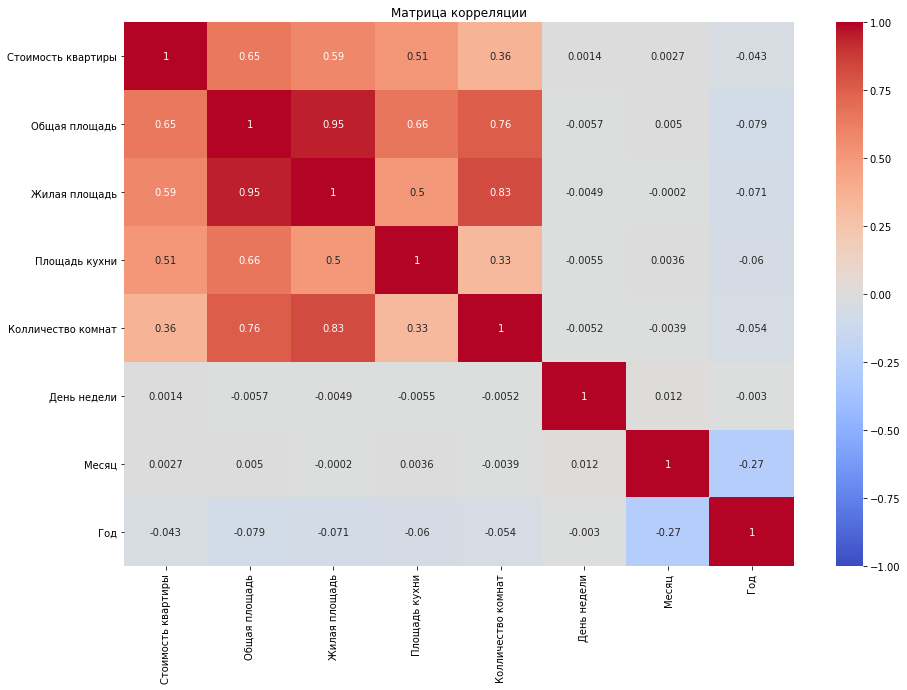

In [27]:
# Визуализируем матрицу корреляции
plt.figure(figsize = (15, 10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1,
            cmap='coolwarm', annot=True,
            yticklabels=corr_name_rus,
            xticklabels=corr_name_rus)
plt.title('Матрица корреляции')
plt.show()

***Вывод:***

Видно, что наибольшая положительная линейная связь между стоимостью квартиры и ее площадью. Зависимость прямопропорциональная - чем больше стоимость квартиры, тем больше ее площадь. Положительная линейная связь отмечается также между стоимостью квартиры и количеством комнат. Связь отличается примерно в 1.5 раза от связи между стоимостью квартиры и площадтю. Соответственно чем количество комнат больше, тем больше стоимость квартиры. Так же заметна умеренная связь между площадью кухни и ценой квартиры, но срее всего эта корреляция выхожит из увелечения общей площади, а не только площади кухни, тк эти значения ростут зачастую одновременно. Между стоимостью квартиры и днем недели, месяцем или годом размещения объявления  отсутствует линейная связь.

<div class="alert alert-block alert-info">
<b>КОММЕНТАРИЙ ОТ УЧЕНИКА: Интерпретировал полученные значения коэф. корреляции.) </b><br>

<div class="alert alert-block alert-success">

**Комментарий ревьювера v2 (все отлично)**
    
Принято👍
</div>

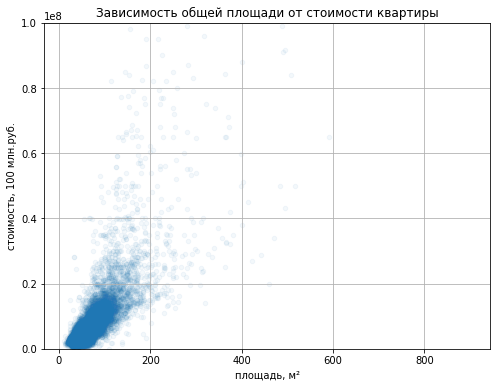

Корреляция цены и общей площади: 

            last_price  total_area
last_price    1.000000    0.739123
total_area    0.739123    1.000000 



In [28]:
# Зависимость цены от общей площади
df.plot(x = 'total_area',
        y='last_price',
        kind ='scatter',
        grid=True, 
        style='o',
        figsize=(8, 6),
        legend=True,
        alpha = 0.05
       )

plt.title('Зависимость общей площади от стоимости квартиры')
plt.xlabel('площадь, м²')
plt.ylabel('стоимость, 100 млн.руб.')
plt.ylim(0, 100000000)
plt.show()
print('Корреляция цены и общей площади:','\n')
print(df.pivot_table(index='floor', values=['total_area', 'last_price']).corr(),'\n')

Из графика видно, что больше всего данных для квартир стоимостью до 20 млн. руб. и площадью до 150 кв.м. Зависимость прямопропорциональная - чем больше площадь квартиры, тем выше цена.

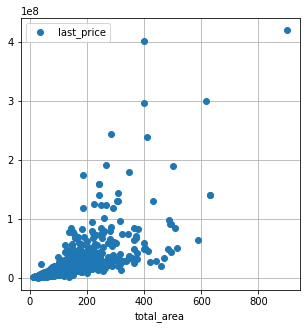

Корреляция цены и общей площади: 

            last_price  total_area
last_price    1.000000    0.739123
total_area    0.739123    1.000000 



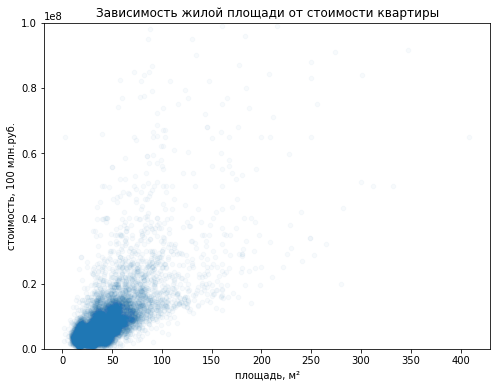

Корреляция цены и жилой площади: 

             last_price  living_area
last_price     1.000000     0.626853
living_area    0.626853     1.000000 

Из графика видно, что больше всего данных для квартир стоимостью до 20 млн. руб. и жило площадью до 75 м². Зависимость прямопропорциональная - чем больше жилаяплощадь квартиры, тем выше ее стоимость.


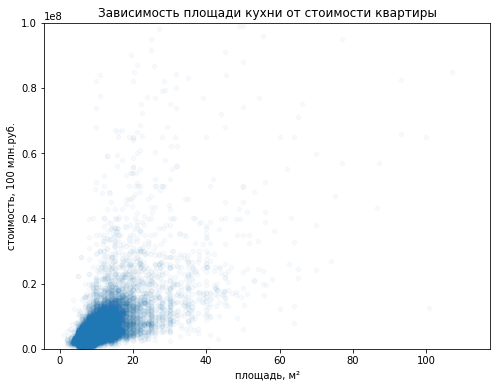

Корреляция цены и площади кухни: 

                      city_centers_nearest  last_price
city_centers_nearest              1.000000    0.158527
last_price                        0.158527    1.000000 

Из графика видно, что больше всего данных для квартир стоимостью до 20 млн. руб. и площадью кухни до 18 м². Зависимость прямопропорциональная - чем больше площадь кухни, тем выше ее стоимость.


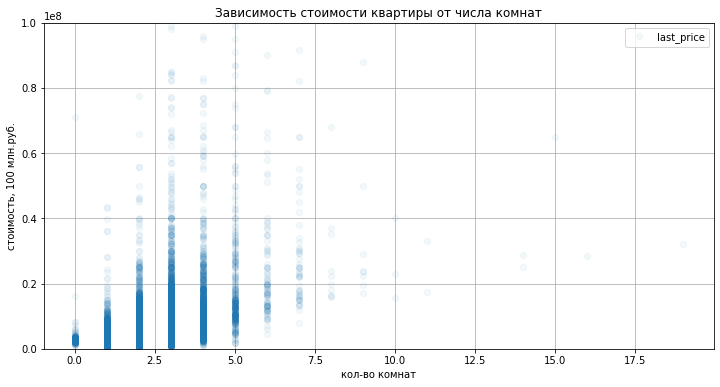

Корреляция цены и числа комнат: 

            last_price     rooms
last_price    1.000000  0.435721
rooms         0.435721  1.000000 

Из графика видно, что больше всего данных для квартир стоимостью до 20 млн. руб и кол-вом комнат от 1 до 3. Для этого диапазона: с учеличение числа комнат до 3 комнат стоимость квартир растет, от 3 до 4 - цена примерно одинаковая, для 5 комнат стоимость снижается. Это можно объяснить тем, что в старом фонде есть 5-ти комнатные квартиры с маленькой площадью комнат.


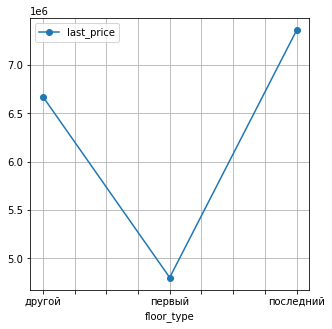

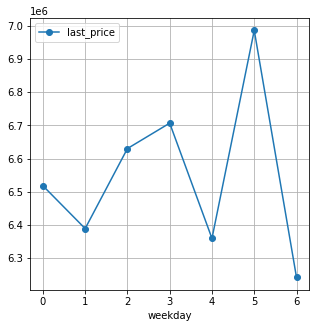

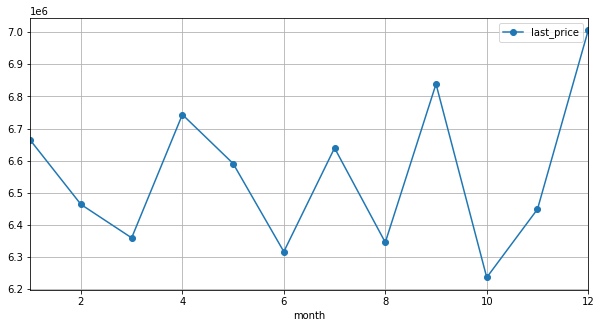

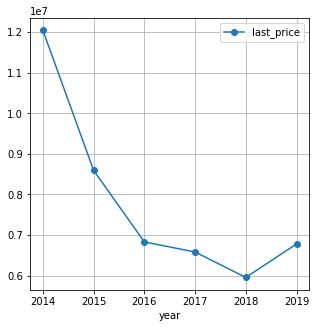

In [29]:
# Зависимость цены от общей площади
(
    df.pivot_table(index='total_area', values='last_price')
    .plot(grid=True, style='o', figsize=(5, 5))
)
plt.show()
print('Корреляция цены и общей площади:','\n')
print(df.pivot_table(index='floor', values=['total_area', 'last_price']).corr(),'\n')

# Зависимость цены от жилой площади
# используем тип графика scatter
df.plot(
    x='living_area',
    y ='last_price',
    kind ='scatter',
    figsize=(8, 6),
    legend=True,
    alpha = 0.03
)

plt.title('Зависимость жилой площади от стоимости квартиры')
plt.xlabel('площадь, м²')
plt.ylabel('стоимость, 100 млн.руб.')
plt.ylim(0, 100000000)
plt.show()
print('Корреляция цены и жилой площади:','\n')
print(df.pivot_table(index='floor', values=['living_area', 'last_price']).corr(),'\n')
print(f'Из графика видно, что больше всего данных для квартир стоимостью до 20 млн. руб. и жило площадью до 75 м². Зависимость прямопропорциональная - чем больше жилаяплощадь квартиры, тем выше ее стоимость.')

# Зависимость цены от площади кухни 
df.plot(
    x='kitchen_area',
    y ='last_price',
    kind ='scatter',
    figsize=(8, 6),
    legend=True,
    alpha = 0.03
)

plt.title('Зависимость площади кухни от стоимости квартиры')
plt.xlabel('площадь, м²')
plt.ylabel('стоимость, 100 млн.руб.')
plt.ylim(0, 100000000)
plt.show()
print('Корреляция цены и площади кухни:','\n')
print(df.pivot_table(index='floor', values=['city_centers_nearest', 'last_price']).corr(),'\n')
print(f'Из графика видно, что больше всего данных для квартир стоимостью до 20 млн. руб. и площадью кухни до 18 м². Зависимость прямопропорциональная - чем больше площадь кухни, тем выше ее стоимость.')


# Зависимость цены от числа комнат
df.plot(
    x = 'rooms', 
    y = 'last_price', 
    style='o', 
    grid=True, 
    figsize=(12, 6), 
    alpha=0.05
    )


plt.title('Зависимость стоимости квартиры от числа комнат')
plt.xlabel('кол-во комнат')
plt.ylabel('стоимость, 100 млн.руб.')
plt.ylim(0, 100000000)
plt.show()
print('Корреляция цены и числа комнат:','\n')
print(df.query('rooms > 0').pivot_table(index='floor', values=['rooms', 'last_price']).corr(),'\n')
print(f'Из графика видно, что больше всего данных для квартир стоимостью до 20 млн. руб и кол-вом комнат от 1 до 3. Для этого диапазона: с учеличение числа комнат до 3 комнат стоимость квартир растет, от 3 до 4 - цена примерно одинаковая, для 5 комнат стоимость снижается. Это можно объяснить тем, что в старом фонде есть 5-ти комнатные квартиры с маленькой площадью комнат.')


# Зависимость цены от типа этажа
(
    df.pivot_table(index='floor_type', values='last_price')
    .plot(grid=True, style='o-', figsize=(5, 5))
)
plt.show()

#Зависимость цены от даты размещения

(
    df.pivot_table(index='weekday', values='last_price')
    .plot(grid=True, style='o-', figsize=(5, 5))
)
plt.show()

# Зависимость от месяца размещения
(
    df.pivot_table(index='month', values='last_price')
    .plot(grid=True, style='o-', xlim=(1,12), figsize=(10, 5))
)
plt.show()

# Зависимость от года размещения
(
    df.pivot_table(index='year', values='last_price')
    .plot(grid=True, style='o-', figsize=(5, 5))
)
plt.show()

<div class="alert alert-block alert-success">

**Комментарий ревьювера (все отлично)**
    
Для категориальных данных, как тип этажа, кол-во комнат и даты размещения объявления усредненные показатели подходят, так как зависимость нелинейна.
</div>

***Вывод***

***Площадь***

Чем больше площадь, тем выше стоимость. Корреляция этих параметров крайне высокая. Число комнат влияет на цену (больше комнат - больше цена), однако зависимость ниже, чем у площади. Можно сделать два вывода: бывают квартиры с большими по площади комнатами;

***Размер кухни***

Чем больше кухня, тем больше цена на эту квартиру, кореляция умеренная, но скорее всего это связано с общей площадью квартиры, так как эти параметры ростут зачастую вместе.

***Этаж***

Первый этаж непосредственно влияет на стоимость квартиры - в среднем квартиры на 1-м этаже значительно дешевле. Чуть дороже последний этаж. Наибольшая стоимость у квартир, расположенных не на 1-м и не на последнем этаже.

***Зависимость от дня, месяца и года***

День недели: дороже всего квартиры, опубликованные в среду, дешевле всего - в субботу.

Месяц: дороже всего квартиры, продающиеся с апреля, дешевле всего - с июня.

Год: квартиры очень сильно подешевели в 2016-2018 годах, что, вероятно, вызвано некоторым кризисом 2014-2015 годов. В 2019 году цены снова стали повышаться, т.к. экономика и зарплаты скорее на подъёме.

## Дополненны вывод:
***На общую (полную) стоимость объекта больше всего влияет общая площадь квартиры и этаж расположения квартиры. Чем больше площадь, тем выше стоимость. На первом и последнем этажах стоимость квартиры меньше, чем на остальных. Дата публикации объявления на стоимость не влияет***



### 4. Сравнение средней стоимости квадратного метра в топ-10 городов

In [30]:
# Сравниваем среднюю стоимость квадратного метра в топ-10 городов по числу объявлений
city_ten = df['locality_name'].value_counts().head(10)
city_sm_price = df.query('locality_name in (@city_ten.index)').pivot_table(values='sm_price', index='locality_name')
city_sm_price = city_sm_price.astype(int)
city_sm_price.sort_values('sm_price', ascending=False)

,sm_price
locality_name,
санкт-петербург,114868
пушкин,103125
кудрово,95260
парголово,90175
мурино,86040
шушары,78550
колпино,75424
гатчина,68745
всеволожск,68654


***Вывод***

Как и следовало ожидать, самая большая стоимость квадратного метра в городе Санкт-Петербурге, далее идут города спутники, которые находжятся вблизи города.

Объеденяющие факты о городах, которые оказались в топ 10 - это близкое удаление от города, это и оъясняет стоимость. Люди могут работать в городе, но при этом достаточно быстро добраться до дома


### Выделим квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислим их среднюю стоимость на разном удалении от центра


In [31]:
df.query('locality_name == "санкт-петербург"')['distans'].describe()

count    15591.000000
mean        11.583414
std          4.854068
min          0.000000
25%          8.000000
50%         12.000000
75%         15.000000
max         29.000000
Name: distans, dtype: float64

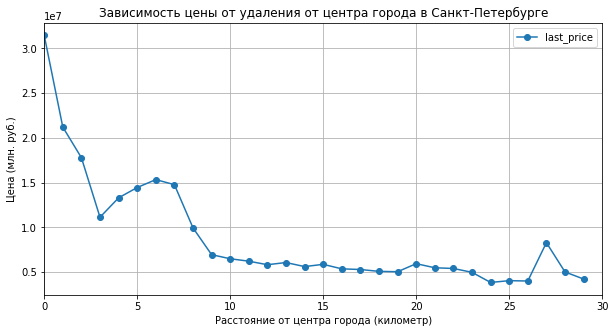

Таблица средней стоимость квартир в зависимости от удаления центра города Санкт-Петербург


,last_price
distans,
0.0,3.144912e+07
1.0,2.120672e+07
2.0,1.778832e+07
3.0,1.113739e+07
4.0,1.330428e+07
5.0,1.445600e+07
6.0,1.533842e+07
7.0,1.477515e+07
8.0,9.949111e+06


In [32]:
(
    df.query('locality_name == "санкт-петербург"')
    .pivot_table(index='distans', values='last_price')
    .plot(grid=True, style='o-', xlim=(0,30), figsize=(10, 5))
)
plt.title('Зависимость цены от удаления от центра города в Санкт-Петербурге')
plt.xlabel('Расстояние от центра города (километр)')
plt.ylabel('Цена (млн. руб.)')
plt.show()
print('Таблица средней стоимость квартир в зависимости от удаления центра города Санкт-Петербург')
df.query('locality_name == "санкт-петербург" and distans<10').pivot_table(values='last_price', index='distans')

***Вывод***

Как и следовало ожидать, чем дальше квартира удалена от центра, тем меньше она стоит.



## Общий вывод

В процессе исследования объявлений о продаже квартир были выполнены следующие этапы и сделаны выводы:
    
Изучили общую информацию о данных
В данных 23699 записи. Для целого ряда столбцов, есть пропущенные значения и некорректный тип данных. По гисторгаммам видно, что в данных есть аномальные значения. Явные дубликаты отсутствуют. Данные признаны полными и достаточными для исследования.

Выполнена предобработка данных:

- Переименовали название столбца ***cityCenters_nearest*** на ***city_centers_nearest***.
- Заполнили явные пропуски в таблице, округлили значение до значащих величин.
- Изменили тип данных, в соответствии с данными находящимися в столбцах.

Сделали вывод о причинах появления пропусков:
- Человеческий фактор.
- Несовершенство программной оболочки (не все поля обязательные).
- Возможны программные сбои.

Добавлены новые столбцы в таблицу для проведения следующего этапа:

- ***price_square_meter*** - цена квадратного метра объекта с точностью до двух знаков после запятой.
- ***day_publication*** - день недели публикации объявления (0 — понедельник, 1 — вторник и так далее).
- ***month_publication*** - месяц публикации объявления.
- ***year_publication*** - год публикации объявления.
- ***type_apartment_floor*** - тип этажа квартиры (значения — «первый», «последний», «другой»).
- ***distance*** - расстояние до центра города в целых километрах.

Изучены и описаны параметры:

- Среднестатистическое предложение, это квартира в пятиэтажном доме средней площадью 52 кв. метра с кухней в 6 кв. метров, высотой потолков 2,65 метра, скорее всего однокомнатная или двухкомнатная с маленькими комнатками, на удалении 13 км. или 5 км. от центра города

Изучено, как быстро ***продавались квартиры***

- Среднее значение продажи составляет 180 дня, при этом медианное значение составляет 95 дня, оно более точно характеризует среднее время продажи, так как не зависит от выбросов и нестандартных значений.
- В среднем продажа средне статистической квартиры занимает 2-3 месяца в зависимости от сопутствующих факторов(площади, цены, удалённости от центра).
- Быстрыми продажами можно считать продажи состоявшиеся за 45 дней (в первом квартиле), а необычно долгие продажи после 232 дня и более (после 3 квартиля), которые могут совсем не продаваться.


Определены факторы, которые ***больше всего влияют*** на общую (полную) ***стоимость объекта***:

- Чем больше общая площадь, тем выше стоимость. Корреляция этих параметров крайне высокая.
- Число комнат влияет на цену (больше комнат -> больше жилая площадь -> больше цена), однако зависимость ниже, чем у площади, так как бывают квартиры с большими по площади комнатами и квартиры в центре состоят из малого числа комнат, но стоят достаточно высоко.
- Первый этаж непосредственно влияет на стоимость квартиры - в среднем квартиры на 1-м этаже значительно дешевле. Чуть дороже последний этаж. Наибольшая стоимость у квартир, расположенных не на 1-м и не на последнем этаже.

Посчитана средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

- Наибольшая средняя стоимость квадратного метра, как и ожидалось, в Санкт-Петербурге. Затем идёт Пушкин, что, вероятно, вызвано хорошей застройкой и большим количеством парков. Вполне возможно что данные города пользуются большим спросом из-за хорошей транспортной доступности к городу, эллектрички, метро, общественный транспорт.


Вычислена средняя стоимость квартиры на разном удалении от центра Санкт-Петербурга

- Самые дорогие квартиры в центре города и их стоимость уменьшается c увеличением расстояния от центра города до 7 километров, далее стоимость не зависит от удаления. Отсутствие зависимости более 7 км скорее всего свзязано с приближением к городам спутникам.